## **classify undertones**

Saving yara vein.jpg to yara vein.jpg
Predicted Undertone: Cool


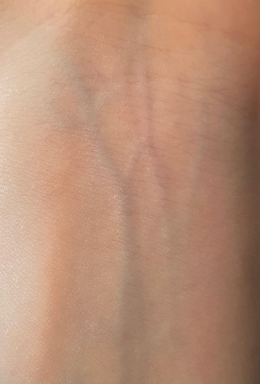

In [4]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
from skimage.color import deltaE_ciede2000

# Function to classify undertones using LAB color space
def classify_undertone(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Define LAB thresholds for skin and veins
    lower_skin_lab, upper_skin_lab = np.uint8([0, 130, 130]), np.uint8([255, 180, 180])
    lower_vein_lab, upper_vein_lab = np.uint8([0, 115, 85]), np.uint8([255, 150, 145])

    # Create masks for skin and veins
    skin_mask = cv2.inRange(lab_image, lower_skin_lab, upper_skin_lab)
    vein_mask = cv2.inRange(lab_image, lower_vein_lab, upper_vein_lab)

    # Extract vein-only areas
    vein_only = cv2.bitwise_and(vein_mask, cv2.bitwise_not(skin_mask))

    # Morphological operations to clean up the result
    kernel = np.ones((5, 5), np.uint8)
    cleaned_vein_mask = cv2.morphologyEx(vein_only, cv2.MORPH_CLOSE, kernel)

    # Calculate mean LAB values for the veins
    mean_l = np.mean(l_channel[cleaned_vein_mask > 0])
    mean_a = np.mean(a_channel[cleaned_vein_mask > 0])
    mean_b = np.mean(b_channel[cleaned_vein_mask > 0])
    mean_lab = [mean_l, mean_a, mean_b]

    # Define LAB values for warm and cool undertones
    warm_lab, cool_lab = [70, 20, 40], [60, -20, -30]

    # Calculate Delta E 2000
    def calculate_delta_e(lab1, lab2):
        return deltaE_ciede2000(np.array(lab1).reshape(1, 1, 3), np.array(lab2).reshape(1, 1, 3))[0][0]

    # Calculate distances for warm and cool
    delta_e_warm = calculate_delta_e(mean_lab, warm_lab)
    delta_e_cool = calculate_delta_e(mean_lab, cool_lab)

    # Classify based on the smallest Delta E value
    return "Warm" if delta_e_warm < delta_e_cool else "Cool"

# Upload a single image file
uploaded = files.upload()
image_filename = list(uploaded.keys())[0]

# Read and resize the uploaded image
image = cv2.imread(image_filename)
if image is not None:
    # Resize the image to 30% of its original size
    scaling_factor = 0.3  # Set scaling factor for the size (30%)
    new_width = int(image.shape[1] * scaling_factor)
    new_height = int(image.shape[0] * scaling_factor)
    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Classify the undertone
    undertone = classify_undertone(image)
    print(f"Predicted Undertone: {undertone}")

    # Display the resized image
    cv2_imshow(image)
else:
    print("Could not read the uploaded image.")


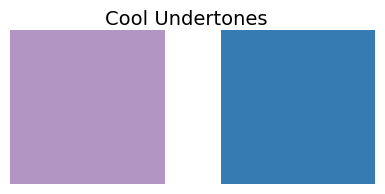

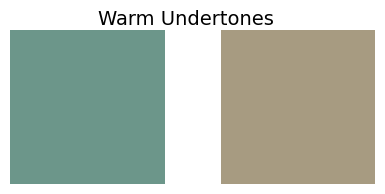

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define RGB values for specific cool and warm undertone checks
cool_rgb_values = [[178, 149, 195], [54, 123, 178]]
warm_rgb_values = [[108, 150, 138], [167, 155, 129]]

# Function to display colors
def display_colors(rgb_values, title):
    fig, ax = plt.subplots(1, len(rgb_values), figsize=(5, 2))
    fig.suptitle(title, fontsize=14)
    for i, rgb in enumerate(rgb_values):
        ax[i].imshow([[np.array(rgb) / 255.0]])
        ax[i].axis('off')
    plt.show()

# Show colors for cool and warm RGB values
display_colors(cool_rgb_values, "Cool Undertones")
display_colors(warm_rgb_values, "Warm Undertones")


# **classify color eyes**

In [ ]:
#!pip install mediapipe
!pip install colormath



In [ ]:
import cv2
import dlib
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from skimage.color import deltaE_ciede2000


Dark Blue - RGB: (97, 143, 159) -> Lab: L*=56.77, a*=-11.35, b*=-13.41
Dark Blue - Approximate Color Patch After Lab Conversion:


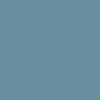

Light Blue - RGB: (126, 173, 186) -> Lab: L*=67.92, a*=-12.42, b*=-11.69
Light Blue - Approximate Color Patch After Lab Conversion:


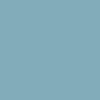

Dark Green - RGB: (91, 113, 82) -> Lab: L*=45.14, a*=-14.52, b*=14.61
Dark Green - Approximate Color Patch After Lab Conversion:


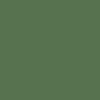

Light Green - RGB: (141, 140, 106) -> Lab: L*=57.52, a*=-5.49, b*=18.35
Light Green - Approximate Color Patch After Lab Conversion:


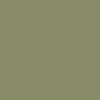

Dark Hazel - RGB: (90, 60, 40) -> Lab: L*=28.27, a*=10.62, b*=17.63
Dark Hazel - Approximate Color Patch After Lab Conversion:


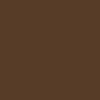

Light Brown (hazel) - RGB: (175, 134, 107) -> Lab: L*=59.18, a*=11.99, b*=20.59
Light Brown (hazel) - Approximate Color Patch After Lab Conversion:


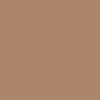

Black - RGB: (30, 30, 30) -> Lab: L*=11.26, a*=-0.00, b*=-0.00
Black - Approximate Color Patch After Lab Conversion:


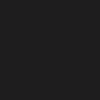

Brown - RGB: (70, 40, 20) -> Lab: L*=19.52, a*=11.83, b*=18.85
Brown - Approximate Color Patch After Lab Conversion:


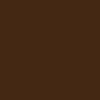

Gray - RGB: (150, 150, 150) -> Lab: L*=62.08, a*=-0.00, b*=-0.01
Gray - Approximate Color Patch After Lab Conversion:


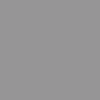

In [ ]:
# Function to convert RGB to Lab
def rgb_to_lab(rgb_color):
    srgb = sRGBColor(*rgb_color, is_upscaled=True)  # RGB values in 0-255 range
    lab = convert_color(srgb, LabColor)
    return lab.lab_l, lab.lab_a, lab.lab_b

# Function to convert Lab back to RGB
def lab_to_rgb(lab_color):
    lab = LabColor(*lab_color)
    srgb = convert_color(lab, sRGBColor)
    rgb = np.clip([srgb.rgb_r, srgb.rgb_g, srgb.rgb_b], 0, 1) * 255  # Scale to 0-255
    return tuple(rgb.astype(int))

# Function to create a color patch
def create_color_patch(rgb_color, patch_size=(100, 100)):
    patch = np.zeros((patch_size[1], patch_size[0], 3), dtype=np.uint8)
    patch[:] = rgb_color[::-1]  # OpenCV uses BGR format
    return patch

# Define iris colors in RGB format
iris_colors_rgb = {
    "Dark Blue": (97, 143, 159),
    "Light Blue": (126, 173, 186),
    "Dark Green": (91, 113, 82),
    "Light Green": (141, 140, 106),
    "Dark Hazel": (90, 60, 40),
    "Light Brown (hazel)": (175, 134, 107),
    "Black": (30, 30, 30),
    "Brown":  (70, 40, 20),
    "Gray": (150, 150, 150)
}

# Convert, print Lab values, and show color approximations
for color_name, rgb_value in iris_colors_rgb.items():
    # Convert RGB to Lab
    lab_value = rgb_to_lab(rgb_value)
    print(f"{color_name} - RGB: {rgb_value} -> Lab: L*={lab_value[0]:.2f}, a*={lab_value[1]:.2f}, b*={lab_value[2]:.2f}")

    # Convert Lab back to RGB for visualization and display the color patch
    rgb_converted = lab_to_rgb(lab_value)
    color_patch = create_color_patch(rgb_converted)
    print(f"{color_name} - Approximate Color Patch After Lab Conversion:")
    cv2_imshow(color_patch)


Saving 407dc8e26226a0efb0af3958ecc79e3f.jpg to 407dc8e26226a0efb0af3958ecc79e3f (1).jpg
Detected Iris Color (RGB): (83.7, 81.80000000000001, 68.7)
Detected Iris Color (RGB): (88.13636363636364, 89.31818181818183, 78.18181818181819)
Delta E for Dark Blue: 27.12
Delta E for Light Blue: 36.23
Delta E for Dark Green: 14.07
Delta E for Light Green: 22.38
Delta E for Dark Hazel (Brown): 17.05
Delta E for Light Brown (hazel): 28.64
Delta E for Black: 18.87
Delta E for Gray: 27.02
Final Iris Color: Dark Green


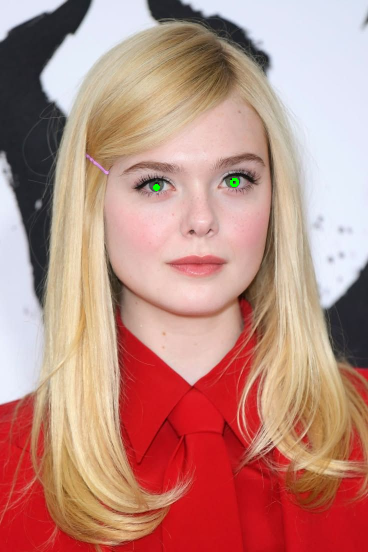

In [ ]:
# Load Dlib's face detector and shape predictor
detector = dlib.get_frontal_face_detector()  # Face detection
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")  # Landmark prediction

# Convert RGB color to Lab color space
def rgb_to_lab(rgb_color):
    # Convert RGB to Lab for better color comparison
    srgb = sRGBColor(*rgb_color, is_upscaled=True)
    lab = convert_color(srgb, LabColor)
    return np.array([lab.lab_l, lab.lab_a, lab.lab_b])

# Predefined iris colors in RGB and their conversion to Lab
iris_colors_rgb = {
    "Dark Blue": (97, 143, 159),
    "Light Blue": (126, 173, 186),
    "Dark Green": (91, 113, 82),
    "Light Green": (141, 140, 106),
    "Dark Hazel (Brown)": (90, 60, 40),
    "Light Brown (hazel)": (175, 134, 107),
    "Black": (30, 30, 30),
    "Gray": (150, 150, 150)
}
iris_colors_lab = {color_name: rgb_to_lab(rgb) for color_name, rgb in iris_colors_rgb.items()}

# Extract iris region from eye landmarks
def get_iris_region(eye_points):
    # Calculate iris center and radius
    x = [p.x for p in eye_points]
    y = [p.y for p in eye_points]
    cx, cy = np.mean(x), np.mean(y)
    radius = min(max(x) - min(x), max(y) - min(y)) // 4
    return int(cx), int(cy), int(radius)

# Classify iris color
def classify_iris_color(image_rgb, iris_region):
    # Extract iris region and calculate average color
    cx, cy, radius = iris_region
    mask = np.zeros_like(image_rgb)
    cv2.circle(mask, (cx, cy), radius, (255, 255, 255), -1)
    masked_img = cv2.bitwise_and(image_rgb, mask)
    gray_masked_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)
    _, thresholded_img = cv2.threshold(gray_masked_img, 50, 255, cv2.THRESH_BINARY)
    refined_mask = cv2.bitwise_and(image_rgb, image_rgb, mask=thresholded_img)
    average_color_rgb = cv2.mean(refined_mask, mask=thresholded_img)[:3]
    return average_color_rgb

# Match iris color to predefined categories
def determine_final_iris_color(left_color, right_color):
    # Average the colors of both eyes and match to predefined colors
    average_rgb = tuple(np.mean([left_color, right_color], axis=0).astype(int))
    average_lab = rgb_to_lab(average_rgb)
    min_delta_e = float('inf')
    closest_color = "Unknown"
    for color_name, lab_value in iris_colors_lab.items():
        delta_e = deltaE_ciede2000(average_lab, lab_value)
        if delta_e < min_delta_e:
            min_delta_e = delta_e
            closest_color = color_name
    return closest_color

# Process an input image
def process_image(image):
    # Resize and prepare the image
    scale_percent = 50  # Resize to reduce computation
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)  # Detect faces

    for face in faces:
        landmarks = predictor(gray, face)  # Get facial landmarks
        left_eye = [landmarks.part(i) for i in range(36, 42)]
        right_eye = [landmarks.part(i) for i in range(42, 48)]
        left_iris_region = get_iris_region(left_eye)
        right_iris_region = get_iris_region(right_eye)
        left_iris_color = classify_iris_color(image_rgb, left_iris_region)
        right_iris_color = classify_iris_color(image_rgb, right_iris_region)
        final_iris_color = determine_final_iris_color(left_iris_color, right_iris_color)
        print(f"Final Iris Color: {final_iris_color}")
        cv2.circle(image, (left_iris_region[0], left_iris_region[1]), left_iris_region[2], (0, 255, 0), 2)
        cv2.circle(image, (right_iris_region[0], right_iris_region[1]), right_iris_region[2], (0, 255, 0), 2)

    cv2_imshow(image)  # Display the result

# Upload and process the image
uploaded = files.upload()
for filename, file_content in uploaded.items():
    with open(filename, 'wb') as f:
        f.write(file_content)
    image = cv2.imread(filename)
    process_image(image)
